In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, chi2_contingency, f_oneway

# Set visual aesthetics
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


In [7]:
# Load the dataset
df = pd.read_excel("E-commerce Customer Behavior.xlsx")

# Print dataset shape
print("Dataset Shape (rows, columns):", df.shape)

# Check for missing values
print("\nMissing Values Per Column:\n", df.isnull().sum())


Dataset Shape (rows, columns): (350, 11)

Missing Values Per Column:
 Customer ID                 0
Gender                      0
Age                         0
City                        0
Membership Type             0
Total Spend                 0
Items Purchased             0
Average Rating              0
Discount Applied            0
Days Since Last Purchase    0
Satisfaction Level          2
dtype: int64


In [8]:
# Fill missing Satisfaction Level with 'Unknown'
df['Satisfaction Level'].fillna('Unknown', inplace=True)


<ipython-input-8-f6604bc91538>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Satisfaction Level'].fillna('Unknown', inplace=True)


In [9]:
# Create derived features
df['Age Group'] = pd.cut(df['Age'], bins=[20, 30, 40, 50], labels=['20-30', '31-40', '41-50'], include_lowest=True)
df['Spend per Item'] = df['Total Spend'] / df['Items Purchased']
df['Churn Risk'] = df['Days Since Last Purchase'] > 30
df['High Value Customer'] = df['Total Spend'] > df['Total Spend'].quantile(0.75)
df['Frequent Buyer'] = df['Items Purchased'] > df['Items Purchased'].median()
df['Recent Buyer'] = df['Days Since Last Purchase'] < 15


In [10]:
# Summary statistics for all columns
print("Summary Statistics for Dataset:\n", df.describe(include='all'))


Summary Statistics for Dataset:
         Customer ID  Gender         Age      City Membership Type  \
count    350.000000     350  350.000000       350             350   
unique          NaN       2         NaN         6               3   
top             NaN  Female         NaN  New York            Gold   
freq            NaN     175         NaN        59             117   
mean     275.500000     NaN   33.597143       NaN             NaN   
std      101.180532     NaN    4.870882       NaN             NaN   
min      101.000000     NaN   26.000000       NaN             NaN   
25%      188.250000     NaN   30.000000       NaN             NaN   
50%      275.500000     NaN   32.500000       NaN             NaN   
75%      362.750000     NaN   37.000000       NaN             NaN   
max      450.000000     NaN   43.000000       NaN             NaN   

        Total Spend  Items Purchased  Average Rating Discount Applied  \
count    350.000000       350.000000      350.000000             

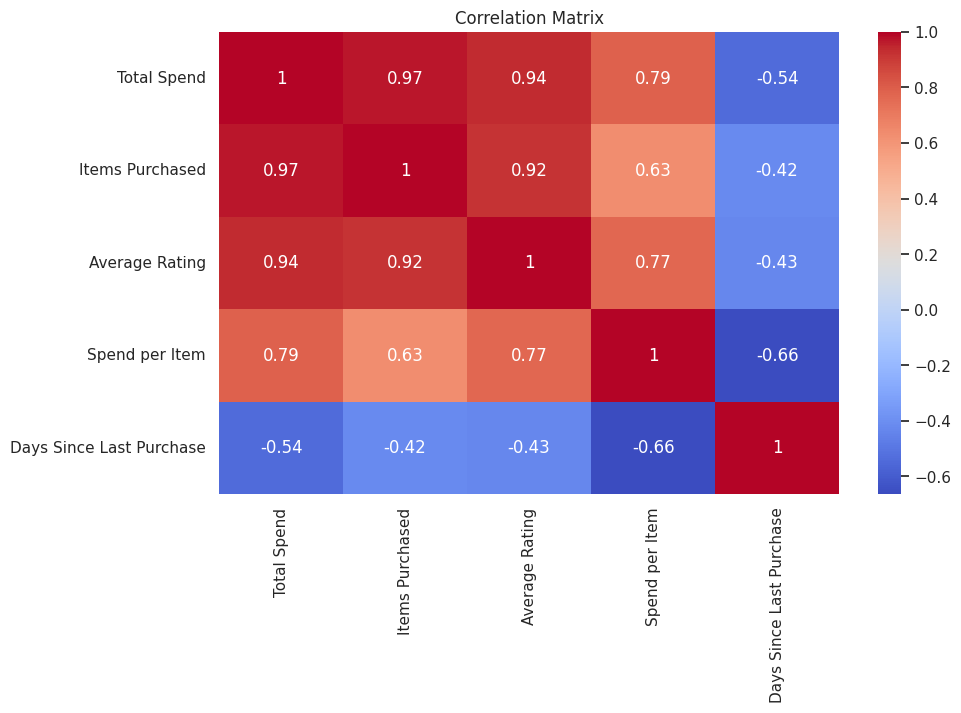

In [11]:
# Compute correlation between numerical features
correlation_matrix = df[['Total Spend', 'Items Purchased', 'Average Rating', 'Spend per Item', 'Days Since Last Purchase']].corr()

# Display heatmap of correlations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


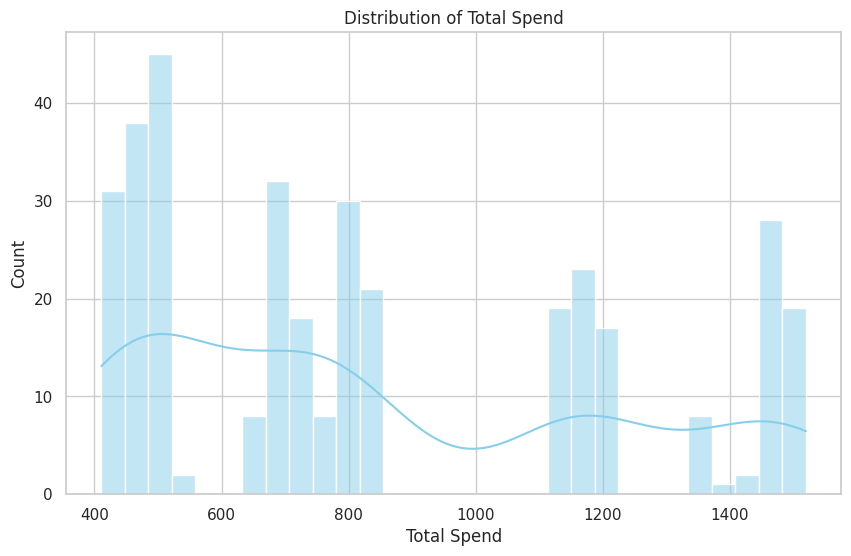

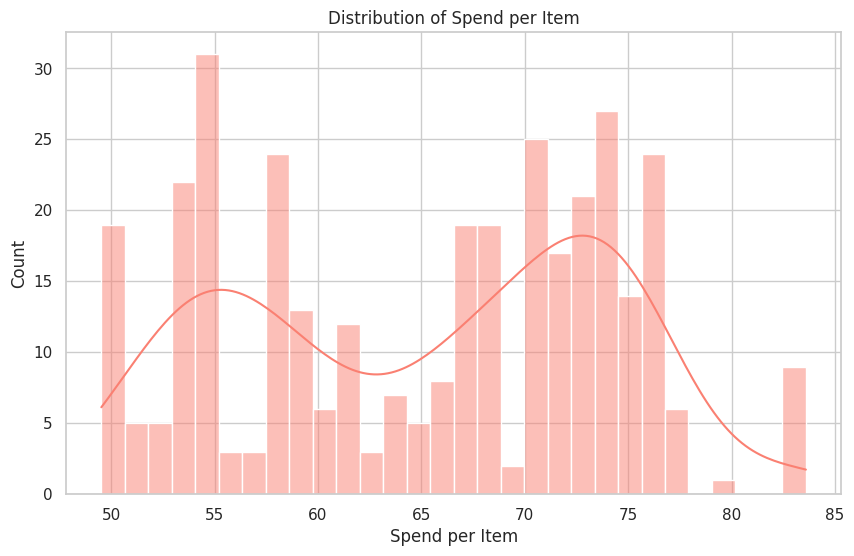

In [12]:
# Histogram of total spend
sns.histplot(df['Total Spend'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Total Spend")
plt.show()

# Histogram of spend per item
sns.histplot(df['Spend per Item'], bins=30, kde=True, color='salmon')
plt.title("Distribution of Spend per Item")
plt.show()


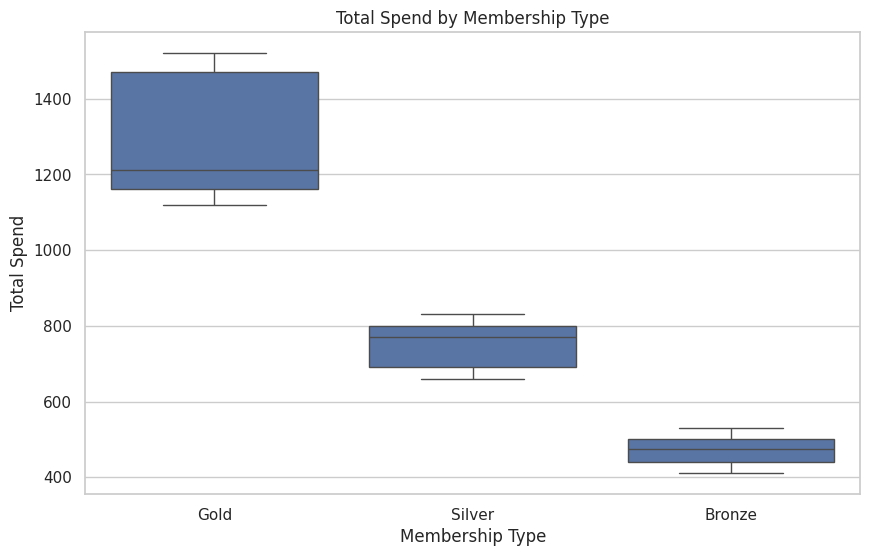

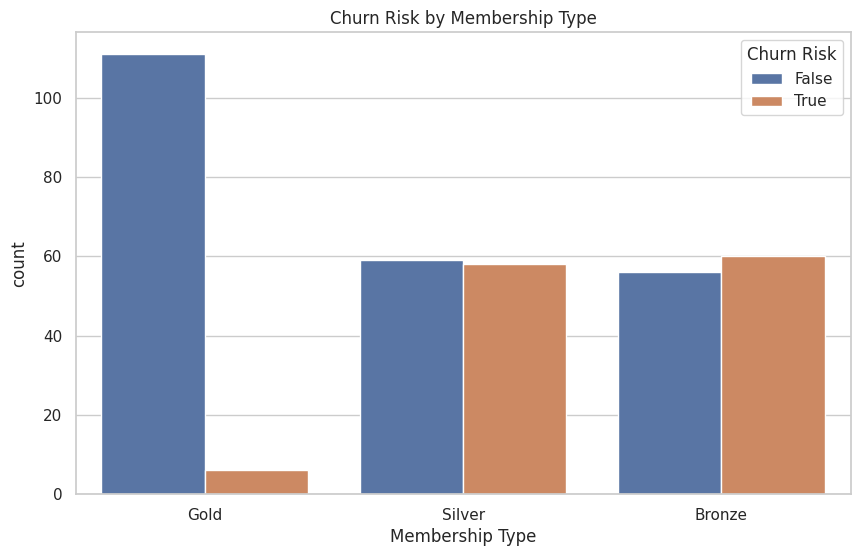

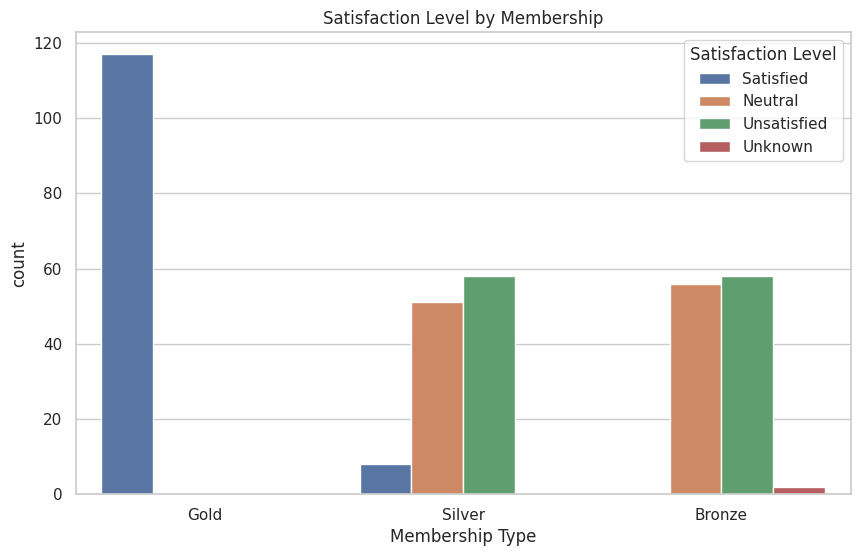

In [13]:
# Total Spend by Membership Type
sns.boxplot(data=df, x='Membership Type', y='Total Spend')
plt.title("Total Spend by Membership Type")
plt.show()

# Churn Risk count by Membership Type
sns.countplot(data=df, x='Membership Type', hue='Churn Risk')
plt.title("Churn Risk by Membership Type")
plt.show()

# Satisfaction by Membership Type
sns.countplot(data=df, x='Membership Type', hue='Satisfaction Level')
plt.title("Satisfaction Level by Membership")
plt.show()


In [14]:
# Pearson correlation between Total Spend and Items Purchased
corr, p = pearsonr(df['Total Spend'], df['Items Purchased'])
print(f"Pearson Correlation (Total Spend vs Items Purchased): Correlation = {corr:.2f}, P-value = {p:.4f}")

# Chi-Square test: Membership Type vs Satisfaction Level
chi2, p, dof, _ = chi2_contingency(pd.crosstab(df['Membership Type'], df['Satisfaction Level']))
print(f"Chi-Square Test (Membership vs Satisfaction Level): Chi2 = {chi2:.2f}, P-value = {p:.4f}")

# ANOVA: Total Spend across Membership Types
groups = [df[df['Membership Type'] == m]['Total Spend'] for m in df['Membership Type'].unique()]
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA (Total Spend by Membership Type): F = {f_stat:.2f}, P-value = {p_value:.4f}")


Pearson Correlation (Total Spend vs Items Purchased): Correlation = 0.97, P-value = 0.0000
Chi-Square Test (Membership vs Satisfaction Level): Chi2 = 320.57, P-value = 0.0000
ANOVA (Total Spend by Membership Type): F = 2294.49, P-value = 0.0000


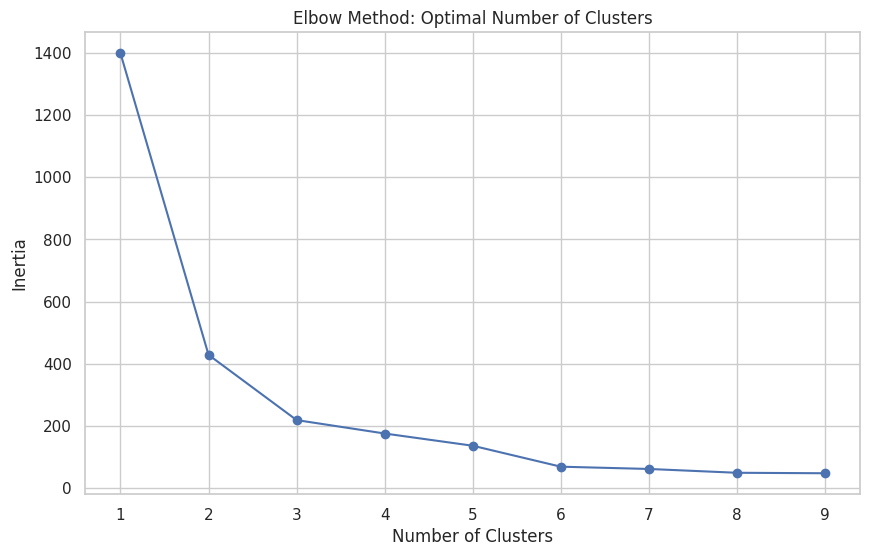

In [15]:
# Features for clustering
features = df[['Total Spend', 'Items Purchased', 'Average Rating', 'Spend per Item']]
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled)

# Elbow method to determine optimal clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


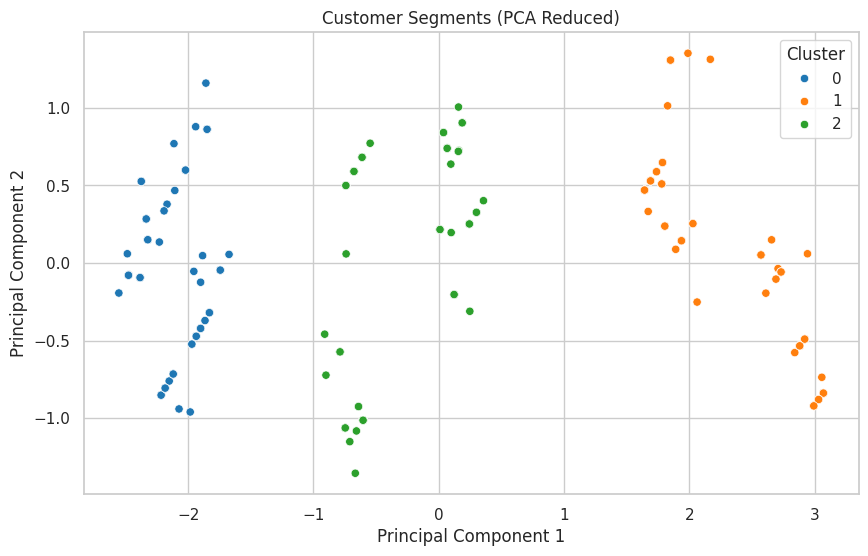

In [16]:
# Apply KMeans with optimal clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled)

# Visualize clusters using PCA components
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=df['Cluster'], palette='tab10')
plt.title("Customer Segments (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [17]:
# Churn risk stats grouped by membership
churn_stats = df.groupby('Membership Type')['Churn Risk'].mean()
print("Average Churn Risk by Membership Type:\n", churn_stats)


Average Churn Risk by Membership Type:
 Membership Type
Bronze    0.517241
Gold      0.051282
Silver    0.495726
Name: Churn Risk, dtype: float64


In [18]:
# Filter high value customers
high_value = df[df['High Value Customer']]

# Summary stats of high-value customers by membership
print("High Value Customer Statistics by Membership Type:\n")
print(high_value.groupby('Membership Type')[['Total Spend', 'Spend per Item']].mean())


High Value Customer Statistics by Membership Type:

                 Total Spend  Spend per Item
Membership Type                             
Gold             1373.614118       73.666023


In [19]:
print("""
Recommendations for Business Strategy:

1. Provide loyalty benefits or exclusive offers to high-value customers to enhance retention.
2. Identify and re-engage customers at risk of churning (no purchase in 30+ days) with email or SMS campaigns.
3. Focus marketing strategies on the 31–40 age group showing higher mid-to-high spend behavior.
4. Consider bundling frequently bought items to increase 'Spend per Item' for low-value segments.
5. Leverage customer clusters for personalized promotions and product recommendations.
6. Monitor recent buyers to send automated feedback or thank-you messages to maintain engagement.
""")



Recommendations for Business Strategy:

1. Provide loyalty benefits or exclusive offers to high-value customers to enhance retention.
2. Identify and re-engage customers at risk of churning (no purchase in 30+ days) with email or SMS campaigns.
3. Focus marketing strategies on the 31–40 age group showing higher mid-to-high spend behavior.
4. Consider bundling frequently bought items to increase 'Spend per Item' for low-value segments.
5. Leverage customer clusters for personalized promotions and product recommendations.
6. Monitor recent buyers to send automated feedback or thank-you messages to maintain engagement.

